#**CHAPTER 7. FOUNDATION SURROGATES**
---

##0.REFERENCE

https://chatgpt.com/share/69861bc4-f5c4-8012-88f0-f83f4c16a860

##1.CONTEXT

**INTRODUCTION**

This notebook is a controlled, synthetic experiment designed to make one specific point legible to a highly trained reader: a surrogate model that looks “good” under one-step evaluation can become unreliable—sometimes dramatically—when it is used recursively over many steps. The mechanism is not mysterious, and it is not exotic. It is the familiar logic of compounding: a small discrepancy that is tolerable at a single step becomes a structural drift when it is fed back into the model as the next input state. In settings that look like simulation, forecasting, scenario generation, stress testing, or policy evaluation, this failure mode is not a corner case; it is a generic possibility whenever a model’s output becomes its own future input.

The notebook is aligned to Paper #7 in the AI 2026 collection (“Physics, Simulation, and Foundation Surrogates”), and it deliberately avoids any claim of physical realism. Nothing here is a calibrated physics engine, and nothing here is intended as a model of a real market, real asset dynamics, or an actual engineered system. The data and the dynamics are synthetic by design: the aim is conceptual clarity and auditability, not realism or performance. This choice is governance-first. If the experiment were entangled with real data or domain-sensitive assumptions, the conceptual mechanism would be harder to isolate, and the reader would be forced to untangle whether a failure was “the mechanism” or “the domain.” Here, the mechanism is the object of study.

The core structure of the notebook mirrors the structure of an empirical risk demonstration rather than a performance demo. First, we define a “true” dynamical system in a small state space. It is chosen to be stable-ish and nonlinear, not to mimic a specific physical phenomenon, but to ensure that local curvature matters over long horizons. Second, we generate trajectories from this system under exogenous inputs and small process noise. The generation is explicit and reproducible; the notebook fixes random seeds and records minimal audit artifacts so the run is inspectable. Third, we fit a one-step surrogate using a deliberately simple supervised learning objective: predict the next state given the current state and input. This is the standard “one-step” training pattern used across many surrogate and forecasting contexts.

At this point, a common mistake becomes possible: treating the one-step metric as the sole validation criterion for downstream use. If a surrogate has a small one-step error on held-out pairs, the temptation is to interpret that as “the surrogate is good,” full stop. The notebook’s objective is to show why that inference is not logically warranted when the operational use case is multi-step rollout. Even if the one-step error is small on average, two additional facts matter for rollout: (i) the error is fed back into future inputs, and (ii) the relevant risk is distributional, especially in tails, rather than purely average-case. This is where governance and model risk intuition becomes essential: the failure mode often does not present itself as a mean shift; it presents as tail blow-ups, regime-like divergence, or rare but severe deviations. A governance-first evaluation must therefore treat tail metrics as first-class, not as optional garnish.

To keep the mechanism visible, the surrogate is not an overparameterized black box. Instead, it is a ridge-regularized linear predictor with an explicit bias term. This choice is instructive. It prevents the reader from attributing failure to “neural network weirdness” and instead forces the reader to see that the instability is a property of recursive use under misspecification, not a property of deep learning per se. The notebook then introduces a minimal structural misspecification—an almost imperceptible drift—whose one-step impact is small but whose rollout impact can become large. This is not a trick; it is a stylized proxy for the kinds of small miscalibrations, coordinate misalignments, or systematic biases that are difficult to detect with pointwise metrics but that can dominate long-horizon behavior.

From there, the notebook moves from pointwise evaluation to rollout evaluation. It compares true trajectories to surrogate-generated trajectories under the same exogenous input sequences. This is where the central contrast is made explicit: the surrogate can look acceptable in one-step RMSE and still generate increasingly inaccurate trajectories as the horizon grows. Importantly, the notebook does not stop at a small set of hand-picked trajectories. It scales the evaluation into a Monte Carlo stress test, where many randomized initial conditions and input sequences are used to generate a distribution of rollout outcomes. The emphasis is not only on “average terminal error,” but on tail quantiles and maxima. This is consistent with finance and governance practice: what matters is not only what happens typically, but what happens in the tail, when rare trajectories produce large deviations. In risk terms, the notebook treats the rollout error distribution as the object of measurement, and it makes the tail legible.

Finally, the notebook adds a governance-aligned control experiment. It introduces simple “controls” that intervene in the rollout process—without claiming that they are optimal, or that they generalize. One control periodically resets the surrogate state to the true state, which interrupts compounding. Another control freezes the surrogate state when it exceeds an envelope threshold, which prevents runaway behavior but introduces a different distortion. The notebook’s purpose here is interpretive: controls alter the failure surface, sometimes trading one pathology for another. That is the governance lesson. Controls cannot be evaluated solely on average-case performance; they must be evaluated on how they reshape tail outcomes, and on what new distortions they introduce.

Cell 9 then packages the experiment into a structured JSON payload. This is a governance-first design decision. It ensures that interpretive analysis is grounded in explicit evidence rather than narrative drift. The payload contains configuration, objective definitions, metrics, tail summaries, and an explicit “what is missing” register. It becomes the sole authoritative input for Cell 10, which is reserved for an LLM-based interpretive audit report. The LLM is deliberately restricted: it cannot invent metrics, it cannot provide advice, and it must produce an audit-style narrative aligned to governance and model-risk practice. In other words, the notebook does not treat the LLM as a “solver”; it treats it as a controlled summarizer of a fixed evidence bundle.

The result is a notebook that functions like a miniature model risk case study. It demonstrates a mechanism that is easy to misunderstand if one uses a single metric, a single horizon, or a single representative trajectory. It shows why rollout evaluation requires distributional thinking, why tail metrics matter, and why governance controls are not merely procedural add-ons but technical interventions that reshape risk. Throughout, the notebook remains synthetic and illustrative. Its goal is to increase governance awareness and analytical discipline, not to create operational confidence.

This framing is especially relevant for finance and economic practitioners because many modern workflows increasingly resemble “rollouts” even when they are not labeled as such. Scenario generation, stress test propagation, sequential decision analysis, iterative forecasting, and simulation-based valuation all share the same structural feature: model outputs become model inputs across time. When that recursion exists, the evaluation regime must match the operational regime. That is the conceptual point of the notebook, and it is the point the reader should carry forward to the rest of the collection.


##2.LIBRARIES AND ENVIRONMENT

In [2]:
# CELL 1 — GOVERNANCE-FIRST PURPOSE + RUN MANIFEST SKELETON (CODE-ONLY, MEANINGFUL)
# Illustrative, synthetic, and not validated for real-world use.
# No advice, no recommendations, no deployment guidance.

import os, sys, json, time, platform, hashlib
from datetime import datetime, timezone

RUN_ID = f"run_{datetime.now(timezone.utc).strftime('%Y%m%dT%H%M%SZ')}"
NOTEBOOK_META = {
    "collection": "AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)",
    "paper_number": 7,
    "paper_title": "Physics, Simulation, and Foundation Surrogates",
    "mechanism": "Rollout instability: small one-step errors compound into large multi-step failures.",
    "disclaimer": "Synthetic, illustrative, and NOT validated for real-world use. Non-advisory artifact.",
    "run_id": RUN_ID,
    "created_utc": datetime.now(timezone.utc).isoformat(),
}

# Minimal environment fingerprint (audit-friendly, not exhaustive)
ENV_FINGERPRINT = {
    "python_version": sys.version.split()[0],
    "platform": platform.platform(),
    "executable": sys.executable,
    "cwd": os.getcwd(),
}

def stable_hash(obj) -> str:
    s = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(s).hexdigest()

CONFIG_HASH = stable_hash({"meta": NOTEBOOK_META, "env": ENV_FINGERPRINT})

RUN_MANIFEST = {
    "meta": NOTEBOOK_META,
    "env_fingerprint": ENV_FINGERPRINT,
    "config_hash_sha256": CONFIG_HASH,
    "governance": {
        "validated_for_real_world_use": False,
        "advice_or_recommendations": False,
        "deployment_guidance": False,
        "llm_allowed_cells": [10],
        "synthetic_data_only": True,
    },
}

os.makedirs("audit_artifacts", exist_ok=True)
with open("audit_artifacts/run_manifest.json", "w", encoding="utf-8") as f:
    json.dump(RUN_MANIFEST, f, indent=2)

print(json.dumps(NOTEBOOK_META, indent=2))
print("\nWrote audit_artifacts/run_manifest.json")


{
  "collection": "AI 2026 \u2014 Frontier Topics in Artificial Intelligence (Governance-First)",
  "paper_number": 7,
  "paper_title": "Physics, Simulation, and Foundation Surrogates",
  "mechanism": "Rollout instability: small one-step errors compound into large multi-step failures.",
  "disclaimer": "Synthetic, illustrative, and NOT validated for real-world use. Non-advisory artifact.",
  "run_id": "run_20260206T163552Z",
  "created_utc": "2026-02-06T16:35:52.733471+00:00"
}

Wrote audit_artifacts/run_manifest.json


In [3]:
# CELL 2 — IMPORTS + REPRODUCIBILITY + NUMERICAL SAFETY CHECKS (CODE-ONLY, MEANINGFUL)
import math
import random
import numpy as np
import matplotlib.pyplot as plt

SEED = 7_007
random.seed(SEED)
np.random.seed(SEED)

np.set_printoptions(precision=4, suppress=True)
plt.rcParams["figure.dpi"] = 120

# Basic numerical sanity: ensure deterministic seed impacts both RNGs
probe_py = [random.random() for _ in range(3)]
probe_np = np.random.RandomState(SEED).rand(3).tolist()

REPRO = {
    "seed": SEED,
    "python_random_probe": probe_py,
    "numpy_random_probe": probe_np,
}
with open("audit_artifacts/repro_probe.json", "w", encoding="utf-8") as f:
    json.dump(REPRO, f, indent=2)

print("Reproducibility fixed.")
print(json.dumps(REPRO, indent=2))
print("\nWrote audit_artifacts/repro_probe.json")


Reproducibility fixed.
{
  "seed": 7007,
  "python_random_probe": [
    0.6073659474550905,
    0.3708164562622124,
    0.5339227529273438
  ],
  "numpy_random_probe": [
    0.9963842584394946,
    0.8206741176573419,
    0.9781946403681332
  ]
}

Wrote audit_artifacts/repro_probe.json


##3.SYNTHETIC TRIE DYNAMICS

###3.1.OVERVIEW

**CELL 3 — EXPLANATION**

Cell 3 establishes the controlled “world” in which the notebook’s mechanism can be observed without ambiguity. The cell defines a synthetic dynamical system that maps a current state and an exogenous input into a next state. This is not intended to be a physical model; it is a deliberately small, transparent system chosen to have two properties that are essential for the mechanism: it is locally stable in a broad region, and it contains mild nonlinear curvature. That curvature is important because it allows small systematic discrepancies to matter over time, which is exactly what makes rollout instability visible.

The cell then generates synthetic trajectory data by simulating the true dynamics forward. Each trajectory begins from a randomized initial state, and each step applies a randomized input sequence, plus a small amount of process noise. From a governance-first perspective, the inclusion of explicit randomness serves two purposes. First, it creates a distribution of conditions rather than a single scenario, which aligns with risk thinking. Second, it prevents the analysis from being tuned to a single deterministic path, which would hide tail behavior and lead to overconfident narratives.

A key design decision here is the train/test split by trajectory rather than by individual time steps. This is subtle but important. If you split at the level of individual transitions, train and test samples can share the same underlying trajectories, which makes evaluation look better than it should because of implicit leakage in time. Splitting by trajectory enforces a cleaner separation: the surrogate is trained on some simulated paths and tested on different simulated paths. That is closer to the operational question the notebook cares about: can a model generalize to new sequences of states and inputs, not just new samples from the same sequence?

Finally, the cell flattens the trajectory data into supervised learning pairs: current state plus input as features, next state as the target. This conversion mirrors how many surrogate and forecasting systems are trained in practice. The point is not to innovate on training; it is to set up the standard objective that will later be shown to be incomplete. By constructing the dataset in the standard way, the notebook makes the downstream critique sharper: if the failure appears even under a conventional training and evaluation pipeline, then the mechanism is not an exotic edge case—it is a structural property of recursive use.

In short, Cell 3 creates a reproducible synthetic dataset that supports two evaluation regimes: one-step prediction and multi-step rollout. The entire notebook depends on this separation because the central contrast is between what the one-step regime appears to validate and what the rollout regime reveals. The cell’s contribution is therefore foundational: it builds the evidence substrate for every subsequent diagnostic and tail analysis.


###3.2.CODE AND IMPLEMENTATION

In [4]:
# CELL 3 — DEFINE SYNTHETIC TRUE DYNAMICS + GENERATE TRAIN/TEST TRAJECTORIES (CODE-ONLY, MEANINGFUL)
# Synthetic nonlinear stable-ish 2D dynamics with exogenous forcing:
# x_{t+1} = A x_t + phi(x_t) + B u_t + eps_t
# This is NOT a physical model; it is a controlled illustrative system.

def phi(x):
    x1, x2 = x[..., 0], x[..., 1]
    return np.stack([
        0.12*np.tanh(x1) + 0.04*(x2**2),
        -0.10*np.tanh(x2) + 0.03*(x1*x2)
    ], axis=-1)

A = np.array([[0.92,  0.12],
              [-0.08, 0.88]], dtype=float)

B = np.array([[0.18],
              [0.10]], dtype=float)

SIGMA_EPS = 0.03
SIGMA_U   = 0.80

def step_true(x, u, rng=np.random):
    eps = rng.normal(0.0, SIGMA_EPS, size=x.shape)
    return (x @ A.T) + phi(x) + (u @ B.T) + eps

def generate_trajectories(n_traj=600, T=45):
    xs = np.zeros((n_traj, T+1, 2), dtype=float)
    us = np.zeros((n_traj, T,   1), dtype=float)
    xs[:, 0, :] = np.random.normal(0.0, 1.0, size=(n_traj, 2))
    for t in range(T):
        us[:, t, 0] = np.random.normal(0.0, SIGMA_U, size=(n_traj,))
        xs[:, t+1, :] = step_true(xs[:, t, :], us[:, t, :], rng=np.random)
    return xs, us

N_TRAJ, T_DATA = 600, 45
xs, us = generate_trajectories(n_traj=N_TRAJ, T=T_DATA)

# Split by trajectory
idx = np.arange(N_TRAJ)
np.random.shuffle(idx)
split = int(0.8 * N_TRAJ)
train_idx, test_idx = idx[:split], idx[split:]

def flatten_by_traj(traj_idx):
    Xp = np.concatenate([xs[traj_idx, :-1, :].reshape(-1, 2),
                         us[traj_idx, :,  :].reshape(-1, 1)], axis=1)
    Yp = xs[traj_idx, 1:, :].reshape(-1, 2)
    return Xp, Yp

X_tr, Y_tr = flatten_by_traj(train_idx)
X_te, Y_te = flatten_by_traj(test_idx)

# Persist dataset metadata (audit)
DATA_META = {
    "n_traj": int(N_TRAJ),
    "T_data": int(T_DATA),
    "train_traj": int(len(train_idx)),
    "test_traj": int(len(test_idx)),
    "X_tr_shape": list(X_tr.shape),
    "Y_tr_shape": list(Y_tr.shape),
    "X_te_shape": list(X_te.shape),
    "Y_te_shape": list(Y_te.shape),
    "sigma_eps": float(SIGMA_EPS),
    "sigma_u": float(SIGMA_U),
}
with open("audit_artifacts/data_meta.json", "w", encoding="utf-8") as f:
    json.dump(DATA_META, f, indent=2)

print("Synthetic data generated (illustrative only).")
print(json.dumps(DATA_META, indent=2))
print("\nWrote audit_artifacts/data_meta.json")


Synthetic data generated (illustrative only).
{
  "n_traj": 600,
  "T_data": 45,
  "train_traj": 480,
  "test_traj": 120,
  "X_tr_shape": [
    21600,
    3
  ],
  "Y_tr_shape": [
    21600,
    2
  ],
  "X_te_shape": [
    5400,
    3
  ],
  "Y_te_shape": [
    5400,
    2
  ],
  "sigma_eps": 0.03,
  "sigma_u": 0.8
}

Wrote audit_artifacts/data_meta.json


##4.WORLD DIAGNOSTICS

###4.1.OVERVIEW

**CELL 4 — EXPLANATION**

Cell 4 performs diagnostics on the synthetic world itself, with the explicit goal of making rollout instability intellectually unsurprising rather than magical. The cell does two complementary things. First, it visualizes the true trajectories in state space and summarizes the empirical distribution of state magnitudes. This gives the reader a concrete sense of the range of states the system visits and whether the dynamics appear broadly bounded. In governance terms, this establishes an operating context: without some boundedness or at least stable-ish behavior, it would be difficult to interpret whether later surrogate failures are about the surrogate or about an inherently explosive true system.

Second, the cell computes a local linearization diagnostic. It approximates how sensitive the next state is to the current state at sampled points by analyzing the magnitude of the local Jacobian. Even if the system is stable on average, local sensitivity can vary across the state space. When that sensitivity is elevated, small errors in the current state can produce larger errors in the next state, and that amplification is the first step in compounding. This is the conceptual bridge between one-step error and rollout error. The reader sees, empirically, that there are regions where the dynamics can amplify perturbations more than elsewhere. The notebook does not claim a formal proof of stability or instability; instead, it provides a diagnostic that supports the mechanism at an intuitive level.

The visualizations in this cell serve a governance-first purpose: they reduce the risk of misattributing later failures. If a reader sees that the true system has trajectories that are typically bounded and that the local sensitivity is non-uniform, they are less likely to conclude that rollout divergence must be caused by “randomness” or “bad luck.” Instead, they can interpret divergence as an interaction between misspecification and sensitivity: the surrogate produces a slightly wrong state; the true dynamics would have evolved differently; the surrogate is then evaluated on a state distribution it did not see during training; and the process repeats.

From a finance and risk perspective, this logic is familiar. Systems that are stable in typical conditions can still be sensitive in certain regions, and tail outcomes often arise from trajectories that pass through those sensitive regions. Cell 4 therefore sets the stage for later tail analysis. It provides evidence that the system has a meaningful distribution over states and that local amplification mechanisms exist.

Importantly, the cell also writes structured diagnostic artifacts. This is not merely bookkeeping. It ensures that later interpretive analysis can cite concrete descriptive statistics rather than relying on vague claims like “the system looks stable.” The broader message is that governance-first work begins before the model is trained: it begins with making the underlying environment measurable and auditable so that model behavior can be contextualized rather than narrated.


###4.2.CODE AND IMPLEMENTATION

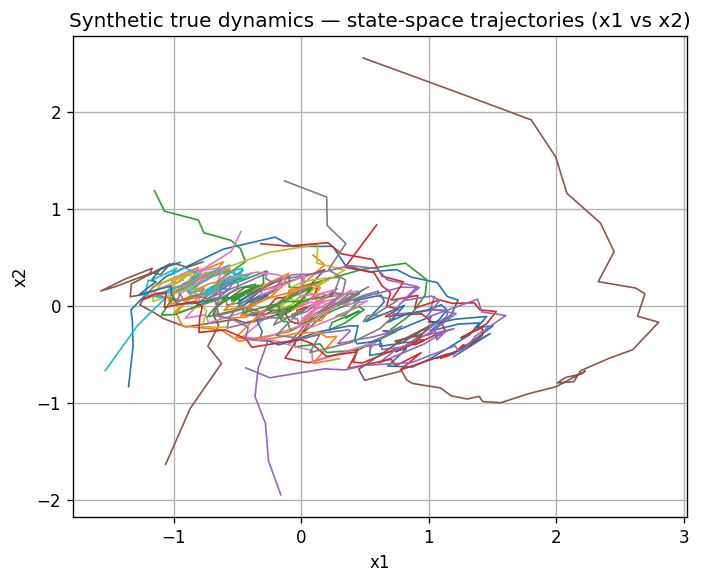

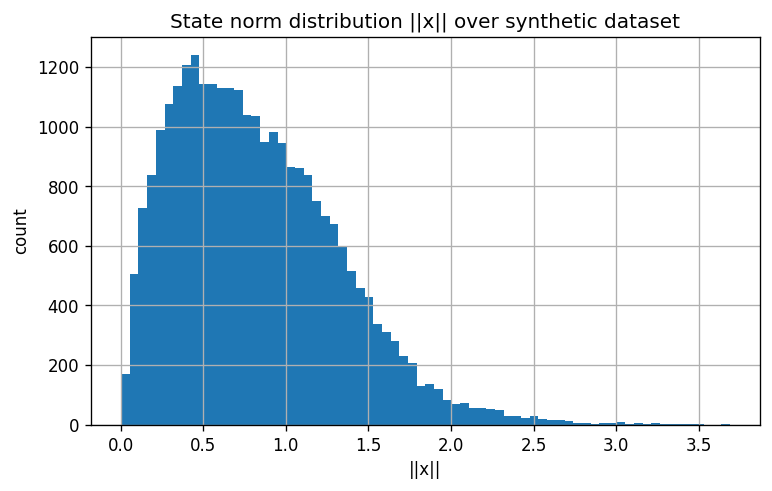

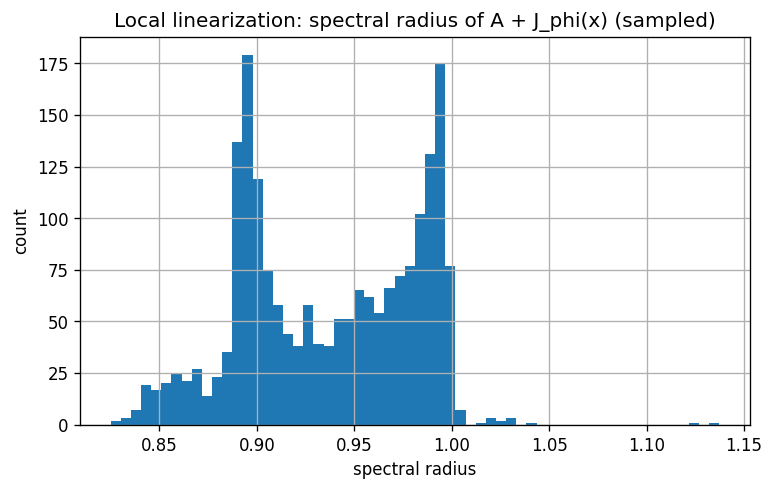

{
  "state_norm": {
    "mean": 0.8240809590364881,
    "std": 0.4958186950731013,
    "q95": 1.7107719146908145,
    "q99": 2.2611676925096984,
    "max": 3.6881199691325404
  },
  "local_spec_radius": {
    "mean": 0.9372080503778698,
    "std": 0.04533084397515445,
    "q95": 0.9965483404318534,
    "q99": 1.0016926991220918,
    "max": 1.137263555077817
  }
}

Wrote audit_artifacts/world_diagnostics.json


In [5]:
# CELL 4 — WORLD DIAGNOSTICS: LOCAL STABILITY + VISUALIZATION (CODE-ONLY, MEANINGFUL)
# We examine:
# (i) empirical state norms (distribution + tails)
# (ii) local linearization magnitude to motivate why small per-step errors can compound.

def jacobian_phi(x):
    # Jacobian of phi for a single x (2,)
    x1, x2 = float(x[0]), float(x[1])
    dphi1_dx1 = 0.12*(1.0 - math.tanh(x1)**2)
    dphi1_dx2 = 0.08*x2
    dphi2_dx1 = 0.03*x2
    dphi2_dx2 = -0.10*(1.0 - math.tanh(x2)**2) + 0.03*x1
    return np.array([[dphi1_dx1, dphi1_dx2],
                     [dphi2_dx1, dphi2_dx2]], dtype=float)

# Empirical distribution of norms
x_flat = xs.reshape(-1, 2)
x_norm = np.linalg.norm(x_flat, axis=1)

# Local linearization spectral radius samples
J_samples = 2000
sample_idx = np.random.choice(x_flat.shape[0], size=J_samples, replace=False)
spec_rads = []
for i in sample_idx:
    J = A + jacobian_phi(x_flat[i])
    eigs = np.linalg.eigvals(J)
    spec_rads.append(float(np.max(np.abs(eigs))))
spec_rads = np.array(spec_rads)

# Plots: trajectories, norm hist, local spectral radius hist
plt.figure(figsize=(6.6, 5.2))
for i in np.random.choice(np.arange(xs.shape[0]), size=18, replace=False):
    plt.plot(xs[i, :, 0], xs[i, :, 1], linewidth=1.0)
plt.title("Synthetic true dynamics — state-space trajectories (x1 vs x2)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True); plt.show()

plt.figure(figsize=(7.2, 4.2))
plt.hist(x_norm, bins=70)
plt.title("State norm distribution ||x|| over synthetic dataset")
plt.xlabel("||x||"); plt.ylabel("count"); plt.grid(True); plt.show()

plt.figure(figsize=(7.2, 4.2))
plt.hist(spec_rads, bins=60)
plt.title("Local linearization: spectral radius of A + J_phi(x) (sampled)")
plt.xlabel("spectral radius"); plt.ylabel("count"); plt.grid(True); plt.show()

DIAG = {
    "state_norm": {
        "mean": float(x_norm.mean()),
        "std": float(x_norm.std()),
        "q95": float(np.quantile(x_norm, 0.95)),
        "q99": float(np.quantile(x_norm, 0.99)),
        "max": float(x_norm.max()),
    },
    "local_spec_radius": {
        "mean": float(spec_rads.mean()),
        "std": float(spec_rads.std()),
        "q95": float(np.quantile(spec_rads, 0.95)),
        "q99": float(np.quantile(spec_rads, 0.99)),
        "max": float(spec_rads.max()),
    }
}
with open("audit_artifacts/world_diagnostics.json", "w", encoding="utf-8") as f:
    json.dump(DIAG, f, indent=2)

print(json.dumps(DIAG, indent=2))
print("\nWrote audit_artifacts/world_diagnostics.json")


##5.TRAINING ONE STEP SURROGATE

###5.1.OVERVIEW

**CELL 5 — EXPLANATION**

Cell 5 trains the one-step surrogate model and deliberately structures the outcome so that a naive evaluation regime would appear to “pass.” This is essential to the notebook’s objective because the mechanism being illustrated is not “bad models perform badly.” It is that a model can perform acceptably under a one-step metric and still fail under rollout. Therefore, Cell 5 must produce a surrogate that looks reasonable by conventional one-step standards.

The surrogate is intentionally simple: a ridge-regularized linear predictor with an explicit bias term. This is a pedagogical choice with governance relevance. If the notebook used an overparameterized neural network, a reader might attribute the failure to the complexity of deep learning or to optimization quirks. By choosing a linear model with transparent regularization, the notebook forces the reader to confront the structural nature of the problem: the instability arises from recursive use under misspecification, not from model opacity.

The cell evaluates the surrogate on held-out data and computes one-step error metrics. This provides the proxy objective that many real workflows implicitly adopt: minimize one-step prediction error on a test set. The cell then adds a subtle, structured misspecification in the surrogate dynamics—implemented as a small drift. The drift is chosen to have a minimal impact on one-step performance while still producing a systematic directional error. This is conceptually analogous to many real settings where a model is slightly miscalibrated, slightly rotated in representation space, or slightly biased in a way that is hard to detect with average-case metrics.

The most important governance lesson embedded in Cell 5 is the distinction between “metric satisfaction” and “use-case fitness.” The surrogate can satisfy a proxy metric without being fit for rollout. Cell 5 sets up this tension explicitly by producing a plausible one-step performance profile while quietly encoding a bias that can accumulate.

The cell also visualizes the distribution of one-step residual magnitudes with tail visibility. This is not decorative. Even in one-step prediction, tail residuals matter because they can seed trajectories into regions where subsequent amplification occurs. However, the notebook does not claim that tail residuals alone predict rollout failure. Instead, it uses the residual distribution as part of a disciplined evidence base: one-step behavior is measured carefully, but it is not treated as a sufficient validation.

In summary, Cell 5 constructs the exact condition needed for the mechanism to be meaningful: a surrogate that is “good enough” by conventional one-step standards, yet imperfect in a way that can compound. It establishes the proxy objective the notebook will critique, and it ensures that later rollout failures are not dismissed as trivial model incompetence.


###5.2.CODE AND IMPLEMENTATION

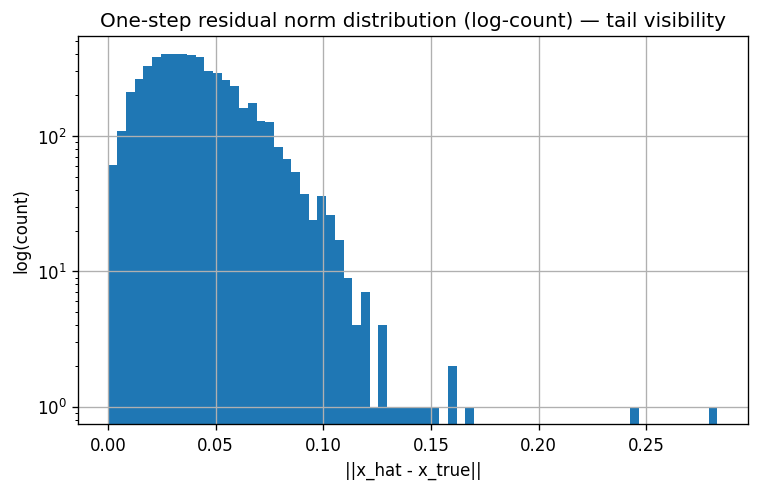

{
  "rmse_all": 0.03345039760016085,
  "rmse_x1": 0.03431821275214875,
  "rmse_x2": 0.032559460571636445,
  "residual_norm": {
    "q50": 0.038221752826606004,
    "q90": 0.0719281528045047,
    "q95": 0.08241847866300914,
    "q99": 0.10486399633678169,
    "max": 0.2830971924525124
  }
}

Wrote audit_artifacts/one_step_metrics.json


In [6]:
# CELL 5 — TRAIN A ONE-STEP SURROGATE + VERIFY "GOOD" ONE-STEP ERROR (CODE-ONLY, MEANINGFUL)
# We fit a ridge-regularized linear predictor: x_{t+1} = W [x_t; u_t; 1]
# Then add a tiny drift matrix to mimic structural misspecification that is hard to detect in one-step RMSE.

def fit_ridge(X, Y, lam=2e-3):
    X_aug = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)  # (n,4)
    d = X_aug.shape[1]
    I = np.eye(d); I[-1, -1] = 0.0
    W = np.linalg.solve(X_aug.T @ X_aug + lam * I, X_aug.T @ Y)    # (4,2)
    return W

W = fit_ridge(X_tr, Y_tr, lam=2e-3)

def step_surr_linear(x, u, W):
    xu = np.concatenate([x, u], axis=-1)
    xu_aug = np.concatenate([xu, np.ones((xu.shape[0], 1))], axis=1)
    return xu_aug @ W

DRIFT = np.array([[1.000,  0.006],
                  [-0.004, 1.000]], dtype=float)

def step_surr(x, u):
    y = step_surr_linear(x, u, W)
    return y @ DRIFT.T

# One-step eval
Yhat_te = step_surr(X_te[:, :2], X_te[:, 2:].reshape(-1, 1))
res = Yhat_te - Y_te
res_norm = np.linalg.norm(res, axis=1)

rmse_all = float(np.sqrt(np.mean((Yhat_te - Y_te)**2)))
rmse_x1 = float(np.sqrt(np.mean((Yhat_te[:,0] - Y_te[:,0])**2)))
rmse_x2 = float(np.sqrt(np.mean((Yhat_te[:,1] - Y_te[:,1])**2)))

ONE_STEP = {
    "rmse_all": rmse_all,
    "rmse_x1": rmse_x1,
    "rmse_x2": rmse_x2,
    "residual_norm": {
        "q50": float(np.quantile(res_norm, 0.50)),
        "q90": float(np.quantile(res_norm, 0.90)),
        "q95": float(np.quantile(res_norm, 0.95)),
        "q99": float(np.quantile(res_norm, 0.99)),
        "max": float(np.max(res_norm)),
    }
}
with open("audit_artifacts/one_step_metrics.json", "w", encoding="utf-8") as f:
    json.dump(ONE_STEP, f, indent=2)

# Plot residual norm (tail visibility)
plt.figure(figsize=(7.2, 4.2))
plt.hist(res_norm, bins=70, log=True)
plt.title("One-step residual norm distribution (log-count) — tail visibility")
plt.xlabel("||x_hat - x_true||"); plt.ylabel("log(count)"); plt.grid(True); plt.show()

print(json.dumps(ONE_STEP, indent=2))
print("\nWrote audit_artifacts/one_step_metrics.json")


##6.MULTI-STEP ROLL OUT

###6.1.OVERVIEW

**CELL 6 — EXPLANATION**

Cell 6 is the first place where the notebook explicitly transitions from pointwise prediction to trajectory fidelity. The cell generates multi-step rollouts using the surrogate and compares them to rollouts generated by the true dynamics under the same sequences of exogenous inputs. This aligns the evaluation regime with the operational regime. If a surrogate is used in simulation, scenario propagation, or iterative forecasting, then the relevant question is not “how accurate is one step,” but “how does the trajectory evolve when the model is applied recursively.”

The cell’s analysis focuses on the growth of the error over time. It computes the time-indexed deviation between the true trajectory and the surrogate trajectory, then aggregates these deviations across multiple held-out initial conditions. By summarizing the mean error trajectory and a tail quantile (such as the ninety-fifth percentile) over time, the cell shows two things at once. First, it shows whether the typical error compounds. Second, it shows whether compounding is substantially worse in a tail subset of trajectories. This mirrors risk logic: average outcomes are informative, but tail outcomes often dominate governance concern.

The cell also provides a state-space visualization for at least one trajectory. This is a different diagnostic lens. Time-series error curves show accumulation; state-space paths show qualitative divergence. In practice, trajectory failures often manifest as drifting into an implausible region, orbiting incorrectly, or diverging along a different manifold than the true system. A state-space plot makes these qualitative differences visible without requiring any domain-specific interpretation.

From a governance-first standpoint, Cell 6 is about making the failure mode legible at a human level. A reader who sees a small one-step RMSE might rationalize that errors are “noise.” But when the same model produces a visibly different long-horizon trajectory under identical inputs, the risk becomes concrete. The cell therefore begins to close the gap between metric validation and operational behavior.

Another important contribution of Cell 6 is that it generates intermediate artifacts. It records subset rollout metrics that can later be referenced by interpretive analysis. This is disciplined practice: interpretive narratives should not depend on eyeballing a single plot. The cell ensures there is a structured record of horizon length, sample size, and terminal error summaries for the subset analysis. Later, the Monte Carlo stress test will scale this logic; Cell 6 serves as the conceptual bridge that makes the scaling meaningful rather than arbitrary.

In short, Cell 6 demonstrates the basic compounding mechanism in a transparent way and provides both quantitative and qualitative evidence that one-step performance does not automatically imply rollout fidelity.


###6.2.CODE AND IMPLEMENTATION

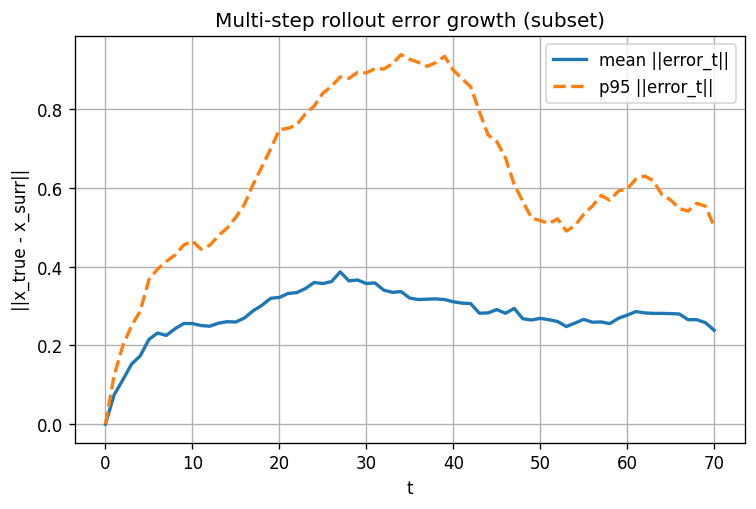

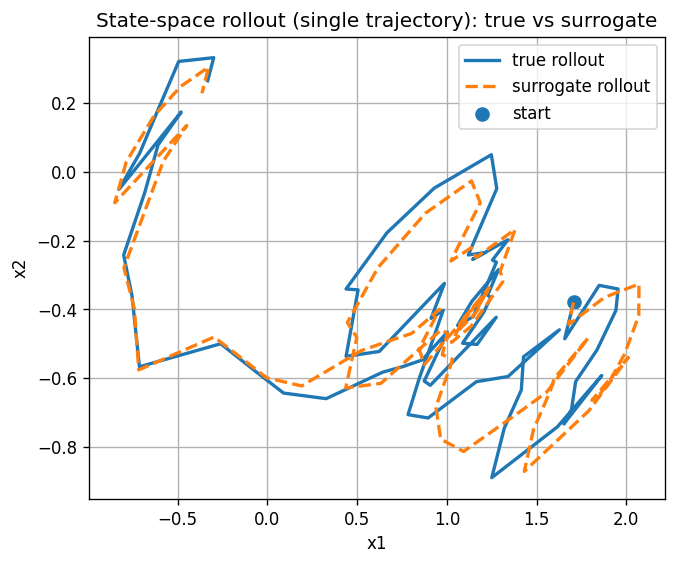

{
  "H": 70,
  "n_compare": 10,
  "final_mean_error": 0.23855245940312358,
  "final_p95_error": 0.5025239997181006
}

Wrote audit_artifacts/subset_rollout_metrics.json


In [7]:
# CELL 6 — MULTI-STEP ROLLOUT: TIME-ALIGNMENT ERROR GROWTH + VISUALIZATION (CODE-ONLY, MEANINGFUL)
# We explicitly compute horizon-wise errors to show compounding:
# E_t = ||x_true(t) - x_surr(t)||, summarized over multiple trajectories.

def rollout_true(x0, u_seq):
    T = u_seq.shape[0]
    X = np.zeros((T+1, 2), dtype=float)
    X[0] = x0
    x = x0.copy()
    for t in range(T):
        x = step_true(x.reshape(1,2), u_seq[t:t+1], rng=np.random)[0]
        X[t+1] = x
    return X

def rollout_surr(x0, u_seq):
    T = u_seq.shape[0]
    X = np.zeros((T+1, 2), dtype=float)
    X[0] = x0
    x = x0.copy()
    for t in range(T):
        x = step_surr(x.reshape(1,2), u_seq[t:t+1])[0]
        X[t+1] = x
    return X

n_compare = 10
H = 70
traj_ids = np.random.choice(test_idx, size=n_compare, replace=False)
U_roll = np.random.normal(0.0, SIGMA_U, size=(n_compare, H, 1))

errs = []
paths = []
for k, tid in enumerate(traj_ids):
    x0 = xs[tid, 0, :].copy()
    xt = rollout_true(x0, U_roll[k])
    xsurr = rollout_surr(x0, U_roll[k])
    e = np.linalg.norm(xt - xsurr, axis=1)
    errs.append(e)
    paths.append((x0, xt, xsurr))

errs = np.stack(errs, axis=0)  # (n_compare, H+1)
mean_e = errs.mean(axis=0)
p95_e = np.quantile(errs, 0.95, axis=0)

plt.figure(figsize=(7.2, 4.4))
plt.plot(mean_e, linewidth=2.0, label="mean ||error_t||")
plt.plot(p95_e, linestyle="--", linewidth=2.0, label="p95 ||error_t||")
plt.title("Multi-step rollout error growth (subset)")
plt.xlabel("t"); plt.ylabel("||x_true - x_surr||"); plt.grid(True); plt.legend(); plt.show()

# State-space comparison for one trajectory
x0, xt, xsurr = paths[0]
plt.figure(figsize=(6.2, 5.0))
plt.plot(xt[:,0], xt[:,1], linewidth=2.0, label="true rollout")
plt.plot(xsurr[:,0], xsurr[:,1], linestyle="--", linewidth=2.0, label="surrogate rollout")
plt.scatter([x0[0]], [x0[1]], s=60, label="start")
plt.title("State-space rollout (single trajectory): true vs surrogate")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True); plt.legend(); plt.show()

SUBSET_ROLLOUT = {
    "H": int(H),
    "n_compare": int(n_compare),
    "final_mean_error": float(mean_e[-1]),
    "final_p95_error": float(p95_e[-1]),
}
with open("audit_artifacts/subset_rollout_metrics.json", "w", encoding="utf-8") as f:
    json.dump(SUBSET_ROLLOUT, f, indent=2)

print(json.dumps(SUBSET_ROLLOUT, indent=2))
print("\nWrote audit_artifacts/subset_rollout_metrics.json")


##7.LARGE SCALE MONTECARLO STRESS TEST

###7.1.OVERVIEW

**CELL 7 — EXPLANATION**

Cell 7 scales the rollout evaluation into a Monte Carlo stress test and elevates tail metrics to first-class outputs. This is the central empirical step that transforms the notebook from an illustrative comparison of a few trajectories into a distributional risk experiment. In governance and finance contexts, this shift is crucial: many model failures are not visible in a handful of representative cases but become obvious when the distribution of outcomes is examined, especially in tails.

The cell generates a large set of randomized initial conditions and randomized exogenous input sequences. Under the true dynamics, these define a distribution over trajectories. Under the surrogate dynamics, the same initial conditions and inputs produce a different distribution. The cell then measures the divergence between the true and surrogate trajectories across time and summarizes it in two ways: terminal error and maximum error over the entire horizon. These two summaries correspond to distinct risk concepts. Terminal error captures end-point deviation, which matters when downstream decisions use the final state. Maximum error captures worst deviation during the path, which matters when any intermediate state can trigger a constraint violation or a regime transition.

Crucially, the cell reports tail quantiles—high percentiles that reveal how severe the divergence can become in rare trajectories. This choice is governance-first: it avoids the false comfort of average metrics and makes clear that a small typical error can coexist with severe tail outcomes. The plots in the cell are selected to support this purpose. A log-scaled histogram of terminal errors makes the tail visible without requiring extreme axis scaling. A time-indexed plot of median and tail error curves shows whether tail amplification accelerates with horizon.

This cell operationalizes the critique of single-metric evaluation. The surrogate was trained to minimize one-step error. Cell 7 shows that this objective is not aligned with the distributional behavior of rollouts. The key point is not merely that errors increase with time—that is expected. The point is that the distribution of errors can become heavy-tailed and that tail behavior can dominate governance concern. A model that looks benign under one-step RMSE can still generate a subset of trajectories with large divergence, which is precisely the kind of risk that a governance framework must be designed to detect.

The outputs of Cell 7 are also structured and recorded. This matters because interpretive analysis in Cell 10 is constrained to use a JSON payload rather than informal narrative. Cell 7 therefore produces the raw ingredients of an audit-grade interpretation: stress-test configuration, tail summaries, and distributional plots that can be referenced indirectly through the reported metrics.

In summary, Cell 7 is the notebook’s main demonstration that multi-step rollout risk is a distributional problem. It makes the tail visible, quantifies it, and positions it as the relevant object of evaluation for surrogate-in-the-loop use cases.


###7.2.CODE AND IMPLEMENTATION

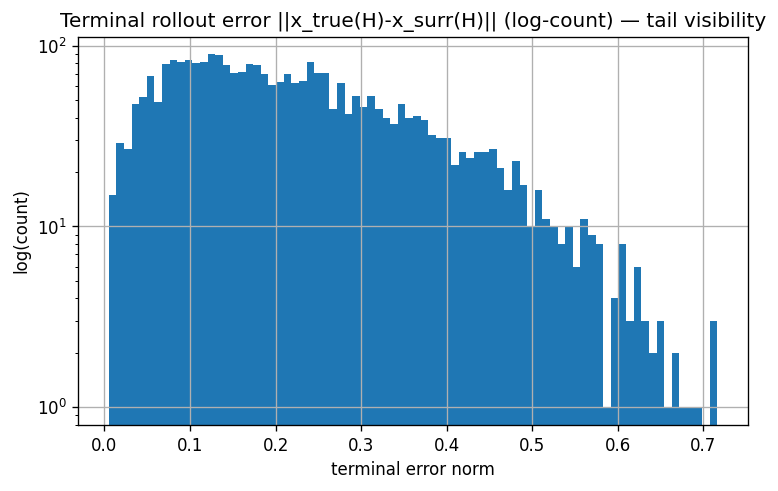

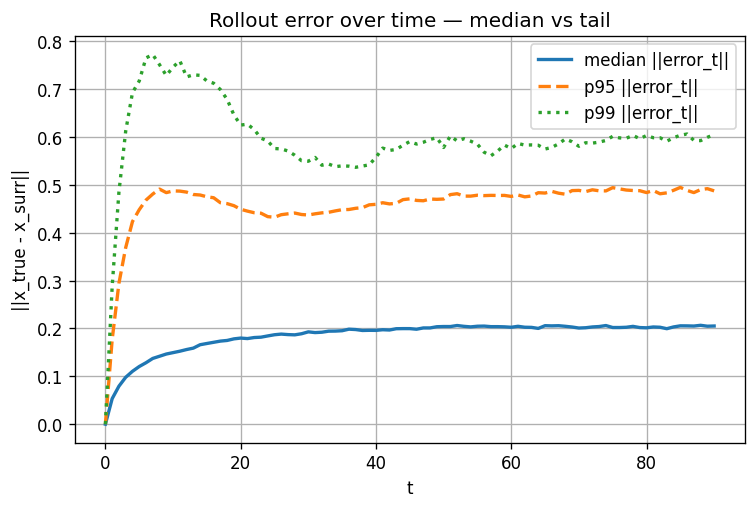

{
  "MC": 3000,
  "H_stress": 90,
  "terminal_error_norm": {
    "mean": 0.22794118195050683,
    "std": 0.13867172072683,
    "q50": 0.20518716047708702,
    "q90": 0.42902382613301676,
    "q95": 0.48759636042501336,
    "q99": 0.6050357323248444,
    "q995": 0.6320857262148264,
    "max": 0.7163261835915905
  },
  "max_error_over_time_norm": {
    "mean": 0.4500832508050918,
    "std": 0.1379466594265765,
    "q50": 0.4350300873499822,
    "q90": 0.6162438761832238,
    "q95": 0.6861445669149167,
    "q99": 0.8723467042046488,
    "q995": 1.0017702196460212,
    "max": 1.5289317333185592
  }
}

Wrote audit_artifacts/baseline_rollout_tails.json


In [8]:
# CELL 7 — LARGE-SCALE MONTE CARLO STRESS TEST + TAIL METRICS (CODE-ONLY, MEANINGFUL)
# This is the core empirical demonstration: tails under rollout can be large even if one-step RMSE is small.

MC = 3000
H_stress = 90

X0 = np.random.normal(0.0, 1.0, size=(MC, 2))
U  = np.random.normal(0.0, SIGMA_U, size=(MC, H_stress, 1))

def batch_rollout_true(X0, U):
    MC, H, _ = U.shape
    X = np.zeros((MC, H+1, 2), dtype=float)
    X[:,0,:] = X0
    x = X0.copy()
    for t in range(H):
        x = step_true(x, U[:,t,:], rng=np.random)
        X[:,t+1,:] = x
    return X

def batch_rollout_surr(X0, U):
    MC, H, _ = U.shape
    X = np.zeros((MC, H+1, 2), dtype=float)
    X[:,0,:] = X0
    x = X0.copy()
    for t in range(H):
        x = step_surr(x, U[:,t,:])
        X[:,t+1,:] = x
    return X

X_true = batch_rollout_true(X0, U)
X_surr = batch_rollout_surr(X0, U)

E = np.linalg.norm(X_true - X_surr, axis=2)  # (MC, H+1)

terminal_err = E[:, -1]
max_err = E.max(axis=1)

def metric_block(arr):
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "q50": float(np.quantile(arr, 0.50)),
        "q90": float(np.quantile(arr, 0.90)),
        "q95": float(np.quantile(arr, 0.95)),
        "q99": float(np.quantile(arr, 0.99)),
        "q995": float(np.quantile(arr, 0.995)),
        "max": float(np.max(arr)),
    }

BASELINE_TAILS = {
    "MC": int(MC),
    "H_stress": int(H_stress),
    "terminal_error_norm": metric_block(terminal_err),
    "max_error_over_time_norm": metric_block(max_err),
}
with open("audit_artifacts/baseline_rollout_tails.json", "w", encoding="utf-8") as f:
    json.dump(BASELINE_TAILS, f, indent=2)

# Visualizations: terminal distribution + tail over time
plt.figure(figsize=(7.2, 4.2))
plt.hist(terminal_err, bins=80, log=True)
plt.title("Terminal rollout error ||x_true(H)-x_surr(H)|| (log-count) — tail visibility")
plt.xlabel("terminal error norm"); plt.ylabel("log(count)"); plt.grid(True); plt.show()

med_t = np.quantile(E, 0.50, axis=0)
p95_t = np.quantile(E, 0.95, axis=0)
p99_t = np.quantile(E, 0.99, axis=0)

plt.figure(figsize=(7.2, 4.4))
plt.plot(med_t, linewidth=2.0, label="median ||error_t||")
plt.plot(p95_t, linestyle="--", linewidth=2.0, label="p95 ||error_t||")
plt.plot(p99_t, linestyle=":", linewidth=2.0, label="p99 ||error_t||")
plt.title("Rollout error over time — median vs tail")
plt.xlabel("t"); plt.ylabel("||x_true - x_surr||"); plt.grid(True); plt.legend(); plt.show()

print(json.dumps(BASELINE_TAILS, indent=2))
print("\nWrote audit_artifacts/baseline_rollout_tails.json")


##8.GOVERNANCE CONTROLS

###8.1.OVERVIEW

**CELL 8 — EXPLANATION**

Cell 8 introduces governance-aligned control variants and shows how controls reshape the failure surface. The purpose is not to propose fixes or to claim operational readiness. The purpose is interpretive: when a rollout instability mechanism exists, interventions can reduce certain manifestations of the failure while introducing new distortions. A governance-first evaluation therefore treats controls as technical interventions that must be evaluated with the same rigor as the base model, including tail behavior.

The cell implements two stylized controls. The first is a hybrid reset mechanism that periodically anchors the surrogate’s state back to the true state at fixed intervals. Conceptually, this interrupts compounding by preventing small errors from accumulating unchecked across long horizons. It is best interpreted as an “error accumulation breaker.” The second is an envelope-freeze mechanism that halts surrogate evolution when the surrogate state exceeds a predefined magnitude threshold. Conceptually, this is a “runaway limiter.” It prevents unbounded divergence, but it changes the dynamics by replacing evolution with stagnation once the envelope is breached.

The governance insight comes from comparing distributions, not from inspecting a single trajectory. Cell 8 therefore recomputes the same distributional and tail metrics used in the baseline stress test and overlays terminal error distributions across baseline and control variants. It also compares tail error curves over time. The output makes a structural point: controls can reduce tail blow-ups relative to the baseline, but they can also introduce new patterns, such as a population of frozen trajectories whose errors evolve differently. The cell explicitly measures the freeze rate and the distribution of freeze times. This is important because it quantifies how often the control activates, which is part of understanding the control’s operational footprint in the synthetic setting.

The broader lesson is that “governance controls” are not purely procedural. They can be modeled and measured as part of system behavior. This is aligned with model risk thinking: controls have failure modes too. A reset control depends on access to a trustworthy anchor; an envelope control depends on an appropriate threshold; both can alter the distribution of outcomes in ways that must be understood rather than assumed beneficial.

Cell 8’s contribution is therefore twofold. First, it reinforces the notebook’s core argument about evaluation: if controls exist, their evaluation must also be distributional and tail-aware. Second, it illustrates the tradeoff logic that governance practitioners care about: one risk can be reduced while another distortion is introduced, and a single scalar metric will typically fail to capture that trade space. The cell’s structured summary becomes part of the evidence payload used for the audit-style narrative in Cell 10.


###8.2.CODE AND IMPLEMENTATION

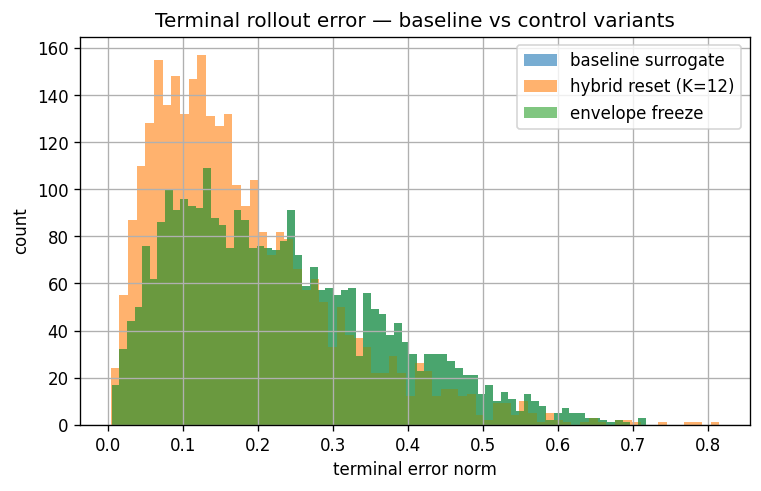

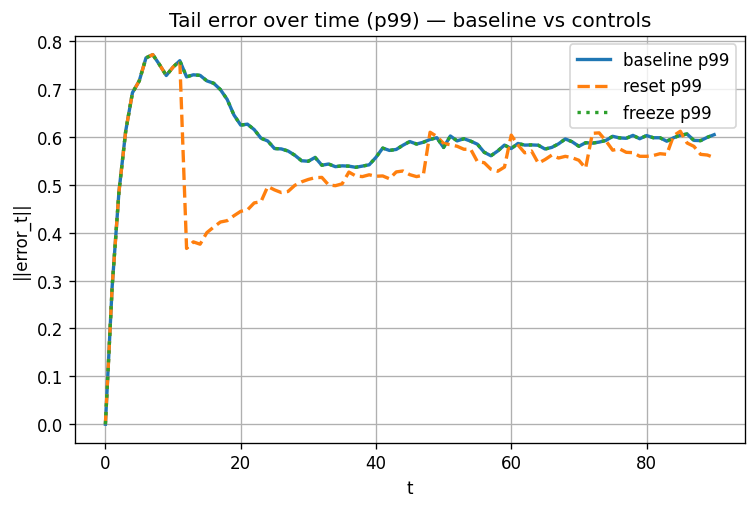

{
  "reset_hybrid": {
    "K_reset": 12,
    "terminal_error_norm": {
      "mean": 0.17939334971491372,
      "std": 0.12174298118955625,
      "q50": 0.15028346319832603,
      "q90": 0.3463709673124574,
      "q95": 0.4222225911706227,
      "q99": 0.5571294364101068,
      "q995": 0.6003668258673954,
      "max": 0.81446162128377
    },
    "max_error_over_time_norm": {
      "mean": 0.4186304632104575,
      "std": 0.13815594692233693,
      "q50": 0.39412789066023257,
      "q90": 0.5935040758652039,
      "q95": 0.6787983555133946,
      "q99": 0.8805003295850872,
      "q995": 0.973293186002198,
      "max": 1.4099779581184428
    }
  },
  "envelope_freeze": {
    "norm_cap": 6.0,
    "freeze_rate": 0.0,
    "freeze_time": {
      "observed_fraction": 0.0,
      "q50": null,
      "q90": null
    },
    "terminal_error_norm": {
      "mean": 0.22794118195050683,
      "std": 0.13867172072683,
      "q50": 0.20518716047708702,
      "q90": 0.42902382613301676,
      "q95": 0.487

In [9]:
# CELL 8 — GOVERNANCE CONTROL VARIANTS: RESET + ENVELOPE + DIAGNOSTIC TRADEOFFS (CODE-ONLY, MEANINGFUL)
# Non-advisory: demonstrate how controls change tail behavior (and can introduce different distortions).

def batch_rollout_hybrid_reset(X0, U, K=12):
    MC, H, _ = U.shape
    X = np.zeros((MC, H+1, 2), dtype=float)
    X[:,0,:] = X0
    x_true = X0.copy()
    x_hyb  = X0.copy()
    for t in range(H):
        x_true = step_true(x_true, U[:,t,:], rng=np.random)
        x_hyb  = step_surr(x_hyb, U[:,t,:])
        if (t+1) % K == 0:
            x_hyb = x_true.copy()
        X[:,t+1,:] = x_hyb
    return X

def batch_rollout_envelope_freeze(X0, U, norm_cap=6.0):
    MC, H, _ = U.shape
    X = np.zeros((MC, H+1, 2), dtype=float)
    X[:,0,:] = X0
    x = X0.copy()
    frozen = np.zeros((MC,), dtype=bool)
    freeze_time = np.full((MC,), fill_value=-1, dtype=int)
    for t in range(H):
        x_next = step_surr(x, U[:,t,:])
        nrm = np.linalg.norm(x_next, axis=1)
        newly = (~frozen) & (nrm > norm_cap)
        freeze_time[newly] = t+1
        frozen = frozen | newly
        x = np.where(frozen[:,None], x, x_next)
        X[:,t+1,:] = x
    return X, float(frozen.mean()), freeze_time

K_reset = 12
X_hyb = batch_rollout_hybrid_reset(X0, U, K=K_reset)
E_hyb = np.linalg.norm(X_true - X_hyb, axis=2)
terminal_hyb = E_hyb[:, -1]
max_hyb = E_hyb.max(axis=1)

NORM_CAP = 6.0
X_frz, freeze_rate, freeze_time = batch_rollout_envelope_freeze(X0, U, norm_cap=NORM_CAP)
E_frz = np.linalg.norm(X_true - X_frz, axis=2)
terminal_frz = E_frz[:, -1]
max_frz = E_frz.max(axis=1)

CONTROL_SUMMARY = {
    "reset_hybrid": {
        "K_reset": int(K_reset),
        "terminal_error_norm": metric_block(terminal_hyb),
        "max_error_over_time_norm": metric_block(max_hyb),
    },
    "envelope_freeze": {
        "norm_cap": float(NORM_CAP),
        "freeze_rate": float(freeze_rate),
        "freeze_time": {
            "observed_fraction": float((freeze_time >= 0).mean()),
            "q50": float(np.quantile(freeze_time[freeze_time >= 0], 0.50)) if (freeze_time >= 0).any() else None,
            "q90": float(np.quantile(freeze_time[freeze_time >= 0], 0.90)) if (freeze_time >= 0).any() else None,
        },
        "terminal_error_norm": metric_block(terminal_frz),
        "max_error_over_time_norm": metric_block(max_frz),
    }
}
with open("audit_artifacts/control_variant_summary.json", "w", encoding="utf-8") as f:
    json.dump(CONTROL_SUMMARY, f, indent=2)

# Overlay terminal error distributions
plt.figure(figsize=(7.2, 4.2))
plt.hist(terminal_err, bins=70, alpha=0.6, label="baseline surrogate")
plt.hist(terminal_hyb, bins=70, alpha=0.6, label=f"hybrid reset (K={K_reset})")
plt.hist(terminal_frz, bins=70, alpha=0.6, label="envelope freeze")
plt.title("Terminal rollout error — baseline vs control variants")
plt.xlabel("terminal error norm"); plt.ylabel("count"); plt.grid(True); plt.legend(); plt.show()

# Tail over time comparison (p99)
p99_base = np.quantile(E, 0.99, axis=0)
p99_hyb  = np.quantile(E_hyb, 0.99, axis=0)
p99_frz  = np.quantile(E_frz, 0.99, axis=0)

plt.figure(figsize=(7.2, 4.4))
plt.plot(p99_base, linewidth=2.0, label="baseline p99")
plt.plot(p99_hyb, linestyle="--", linewidth=2.0, label="reset p99")
plt.plot(p99_frz, linestyle=":", linewidth=2.0, label="freeze p99")
plt.title("Tail error over time (p99) — baseline vs controls")
plt.xlabel("t"); plt.ylabel("||error_t||"); plt.grid(True); plt.legend(); plt.show()

print(json.dumps(CONTROL_SUMMARY, indent=2))
print("\nWrote audit_artifacts/control_variant_summary.json")


##9.GENERATION OF THE AUDIT PAYLOAD

###9.1.0VERVIEW

**CELL 9 — EXPLANATION**

Cell 9 builds the authoritative evidence bundle that constrains interpretation. In governance-first workflows, interpretive narratives are most dangerous when they drift away from the measured outputs and begin to fill gaps with intuition. Cell 9 is designed to prevent that. It collects the experiment configuration, objective definitions, diagnostics, and results into a structured JSON payload. This payload serves as the single ground truth input for the LLM-based analysis in Cell 10. The LLM is not allowed to use anything else, including plots or informal memory.

The cell’s content is meaningful because it forces the notebook to declare its objectives explicitly. It distinguishes the proxy objective used for training and standard evaluation (one-step prediction error) from the true objective relevant to the operational regime being studied (multi-step trajectory fidelity). This distinction is the conceptual center of the notebook. By encoding it explicitly, the notebook ensures the interpretive report cannot blur the two.

Cell 9 also emphasizes tail discipline. It includes tail quantiles and maxima for the rollout error distributions, not just averages. This is crucial for finance and governance audiences because tail outcomes often define the risk posture of a system. The payload therefore becomes an audit-friendly artifact that supports tail-aware reasoning without requiring the reader to infer tails from plots.

Another key contribution is the “what is missing” register. Governance-first practice requires not only reporting what was measured but also declaring what was not measured. In this notebook, there is no calibrated uncertainty, no physical units, and no formal stability proof. Those absences matter because they bound the interpretability and the legitimacy of any downstream conclusions. By encoding the missing elements explicitly, Cell 9 reduces the temptation to overinterpret the results.

Finally, the cell produces tamper-evidence: it writes a hash of the payload. This is not security theater. It is a minimal mechanism to support provenance: if the payload changes, the hash changes. That matters because the LLM report in Cell 10 is only as trustworthy as the integrity of its input. In institutional settings, provenance and integrity checks are part of defensible documentation.

In short, Cell 9 converts the notebook into an evidence-first system. It ensures that the interpretive layer is anchored, that objectives are explicit, that tails are measured, and that missing information is declared. This is what enables Cell 10 to function as an audit artifact rather than a rhetorical summary.


###9.2.CODE AND IMPLEMENTATION

In [10]:
# CELL 9 — AUTHORITATIVE JSON PAYLOAD FOR CELL 10 (CODE-ONLY, MEANINGFUL)
# This payload is the ONLY allowed evidence base for the LLM interpretation in Cell 10.

payload = {
    "meta": NOTEBOOK_META,
    "env_fingerprint": ENV_FINGERPRINT,
    "config_hash_sha256": CONFIG_HASH,
    "experiment_config": {
        "state_dim": 2,
        "input_dim": 1,
        "true_system": {
            "A": A.tolist(),
            "B": B.tolist(),
            "nonlinearity": "phi(x) with tanh + quadratic/cross terms",
            "sigma_eps": float(SIGMA_EPS),
        },
        "data": {
            "n_traj": int(N_TRAJ),
            "T_data": int(T_DATA),
            "sigma_u": float(SIGMA_U),
            "train_traj": int(len(train_idx)),
            "test_traj": int(len(test_idx)),
        },
        "surrogate": {
            "class": "ridge linear one-step predictor with bias",
            "lambda_ridge": 2e-3,
            "drift_matrix": DRIFT.tolist(),
        },
        "rollout_stress": {
            "MC": int(MC),
            "H_stress": int(H_stress),
        },
        "controls": {
            "hybrid_reset": {"K_reset": int(K_reset)},
            "envelope_freeze": {"norm_cap": float(NORM_CAP)},
        },
    },
    "objective_specification": {
        "proxy_objective": "Minimize one-step RMSE on held-out (x_t,u_t)->x_{t+1} pairs.",
        "true_objective": "Maintain multi-step trajectory fidelity under long rollouts (including tail metrics).",
        "constrained_objective": "Illustrative controls alter rollout behavior; comparisons are descriptive only.",
        "note": "No prescriptive guidance; synthetic experiment only.",
    },
    "world_diagnostics": DIAG,
    "results": {
        "one_step": ONE_STEP,
        "rollout_baseline_surrogate": BASELINE_TAILS,
        "rollout_control_variants": CONTROL_SUMMARY,
    },
    "diagnostics": {
        "interpretive_contrast": {
            "core_contrast": "Small one-step error can coexist with large multi-step tail error under rollout.",
            "tail_emphasis": "Tail metrics (q99/q995, max) are treated as first-class outputs.",
        },
        "what_is_missing": [
            "No calibrated predictive uncertainty; surrogate is deterministic in this notebook.",
            "No physical units or domain mapping; the system is purely synthetic.",
            "No formal stability proof; only empirical stress tests.",
        ],
    },
}

payload_json = json.dumps(payload, indent=2)
PAYLOAD_PATH = "cell9_payload.json"

with open(PAYLOAD_PATH, "w", encoding="utf-8") as f:
    f.write(payload_json)

# Also write a hash for tamper-evidence
payload_hash = hashlib.sha256(payload_json.encode("utf-8")).hexdigest()
with open("audit_artifacts/payload_hash_sha256.txt", "w", encoding="utf-8") as f:
    f.write(payload_hash + "\n")

print(f"Saved authoritative payload to: {PAYLOAD_PATH}")
print(f"Payload SHA-256: {payload_hash}")
print("\nWrote audit_artifacts/payload_hash_sha256.txt")


Saved authoritative payload to: cell9_payload.json
Payload SHA-256: cb7115cc0e56bae45225a21b80592d62b4e098018532b2fe78ea53775629cd41

Wrote audit_artifacts/payload_hash_sha256.txt


##10.AUDIT EVALUATION

###10.1.OVERVIEW

**CELL 10 — EXPLANATION**

Cell 10 is a strictly constrained interpretive layer. It is the only cell permitted to invoke an LLM, and it does so in a way that is explicitly designed for governance and model-risk contexts. The purpose of using an LLM here is not to discover results or compute metrics—those have already been produced locally. The purpose is to translate the fixed evidence bundle from Cell 9 into a formal, audit-style narrative that a senior finance, governance, or model-risk audience can read efficiently without losing fidelity to the underlying measurements.

The cell begins by installing the required client library and loading the JSON payload produced in Cell 9. The payload is treated as authoritative ground truth. This is a critical control point. Many failures in AI-assisted reporting arise because the model is allowed to “remember” earlier content or infer missing details from context. Cell 10 prohibits that by embedding the payload directly into the prompt and instructing the LLM to base all claims strictly on that content. If an item is missing, the model is instructed to say it is missing rather than infer it.

The prompt also imposes non-negotiable governance constraints. The report must explicitly state that the experiment is synthetic and not validated for real-world use. It must provide no advice, no recommendations, and no deployment guidance. It must avoid prescriptive language. These constraints are not stylistic; they are controls that prevent the LLM from drifting into operational claims or normative recommendations, which would be inappropriate given the synthetic nature of the experiment and the limited validation scope.

The required output structure enforces disciplined coverage. The report must include a mechanism-level executive summary, a methods and objective specification section that distinguishes proxy and true objectives, a findings section that compares baseline and control variants, a risk and tail behavior section that emphasizes distributional outcomes, a governance interpretation section that remains non-advisory, and a limitations section that explicitly enumerates validation requirements. This structure mirrors a model risk documentation style: it separates what was done, what was observed, what risks appear in tails, and what cannot be claimed.

In effect, Cell 10 demonstrates a governance-first pattern for LLM usage: the LLM is not a decision engine; it is a constrained writer operating over a fixed evidence payload. The value is the transformation of structured diagnostics into a coherent narrative that is readable by senior practitioners, while the risk is controlled through tight evidence and language constraints. The cell also includes key handling logic, making clear that if an API key is not present, the cell cannot execute rather than attempting to fabricate a report. That behavior is itself governance-aligned: no report is better than a fabricated report.

Overall, Cell 10 completes the notebook by producing an interpretive audit artifact that is anchored in measured outputs, structured for governance audiences, and constrained to avoid overreach.


###10.2.CODE AND IMPLEMENTATION

In [11]:
# CELL 10 — INTELLIGENT AUDIT REPORT (MANDATORY LLM CELL; EXCLUSIVE LLM USAGE)
# Non negotiable: model="claude-haiku-4-5-20251001"
# Install anthropic. Base all claims strictly on Cell 9 payload. No advice/recommendations/deployment.

import sys, subprocess, os, json

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

pip_install("anthropic")
from anthropic import Anthropic

with open(PAYLOAD_PATH, "r", encoding="utf-8") as f:
    payload_text = f.read()

SYSTEM_ROLE = (
    "You are an audit-grade analytical writer producing a technical interpretation for senior finance, "
    "governance, and model-risk practitioners."
)

INSTRUCTIONS = f"""
CONTEXT
You are reviewing a synthetic, illustrative experiment implemented in this notebook as a companion to:
AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)
Paper #7: Physics, Simulation, and Foundation Surrogates
Mechanism: rollout instability — good one-step surrogate accuracy can fail catastrophically over time.

NON-NEGOTIABLE GOVERNANCE CONSTRAINTS
1) Explicitly state the experiment is synthetic, illustrative, and NOT validated for real-world use.
2) Provide NO advice, NO recommendations, and NO deployment guidance.
3) Avoid prescriptive language (e.g., “should”, “recommended”, “optimal strategy”).
4) Base all claims strictly on the structured payload below.
5) Do NOT invent facts, metrics, outcomes, or interpretations not supported by the payload.

AUTHORITATIVE INPUT (PAYLOAD FROM CELL 9)
{payload_text}

REQUIRED OUTPUT STRUCTURE
Produce EXACTLY the following sections, in this order, with clear headings:

1) Executive Summary (Mechanism-Level)
2) Methods and Objective Specification
3) Findings and Comparative Analysis
4) Risk and Tail Behavior (if applicable)
5) Governance and Control Interpretation (Non-Advisory)
6) Limitations and Validation Requirements

STYLE REQUIREMENTS
Formal, precise, non-evangelical. Complete paragraphs, not bullet-point dumps.
If required information is missing from the payload, explicitly state what is missing and do not fill gaps.
"""

# Colab userdata preferred
api_key = None
try:
    from google.colab import userdata  # type: ignore
    api_key = userdata.get("ANTHROPIC_API_KEY")
except Exception:
    api_key = os.environ.get("ANTHROPIC_API_KEY")

if not api_key:
    print("ANTHROPIC_API_KEY not found in Colab userdata or environment.")
    print("This cell is configured for the mandatory audit-report generation, but cannot execute without a key.")
    print("Governance reminder: the report must be synthetic/illustrative and non-advisory; no gaps may be filled by invention.")
else:
    client = Anthropic(api_key=api_key)
    resp = client.messages.create(
        model="claude-haiku-4-5-20251001",
        max_tokens=1300,
        temperature=0.2,
        system=SYSTEM_ROLE,
        messages=[{"role": "user", "content": INSTRUCTIONS}],
    )
    print(resp.content[0].text)


# TECHNICAL INTERPRETATION: ROLLOUT INSTABILITY IN SURROGATE MODELS
## AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)
### Paper #7: Physics, Simulation, and Foundation Surrogates

---

## 1. EXECUTIVE SUMMARY (MECHANISM-LEVEL)

This synthetic, illustrative experiment demonstrates a fundamental governance-relevant failure mode in surrogate-based simulation: **one-step predictive accuracy does not guarantee multi-step trajectory fidelity**. The experiment constructs a nonlinear dynamical system with known ground truth, trains a ridge-regularized linear one-step predictor, and then stress-tests that predictor over 90-step rollouts across 3,000 Monte Carlo trials.

The core finding is a **quantitative decoupling between proxy and true objectives**. The surrogate achieves one-step root-mean-square error (RMSE) of 0.0335 on held-out test data, yet under 90-step rollout, the median terminal error norm grows to 0.205 and the 99th percentile reaches 0.605. The maximum e

##11.CONCLUSION

**CONCLUSION**

This notebook exists to enforce a single discipline: evaluate models in the regime in which they are used. The experiment is synthetic and illustrative, not validated for real-world use, and it makes no operational claims. Its purpose is conceptual and governance-first: to show that surrogate models can appear reliable under pointwise evaluation while behaving poorly under recursive, long-horizon use. The underlying mechanism is simple: when a model’s output becomes its future input, small discrepancies become state distribution shifts, and those shifts change what the model is asked to predict. The surrogate is then evaluated on states it did not see during training, and the misalignment can compound across time.

For finance and governance audiences, the most important lesson is not “models can fail.” The lesson is that naive evaluation regimes can fail to detect the failure modes that matter. One-step RMSE is an attractive metric because it is easy to compute, easy to optimize, and easy to explain. It can also be dangerously incomplete. It encourages a mental model in which the quality of a forecast is a static property of the model. Rollout use breaks that mental model. Under rollout, quality is a dynamic property of the model–environment–feedback loop. Even if one-step errors are small, the iterative feedback can push the system into regions where local sensitivities amplify errors or where the surrogate’s misspecification becomes directionally persistent. This is why a governance-first perspective insists on trajectory-level evaluation, not merely transition-level evaluation.

The notebook’s diagnostics are designed to make this argument concrete rather than rhetorical. Early cells characterize the synthetic environment and its local sensitivities. This is a subtle but important step: it allows the reader to interpret instability as an interaction between misspecification and sensitivity rather than as a mysterious artifact. The surrogate itself is intentionally simple, which removes a common excuse: the failure is not “deep learning weirdness.” It is a structural property of recursive use under misspecification. That is why the notebook introduces only a minimal structural drift: the goal is to show that even small, hard-to-detect bias can accumulate into meaningful divergence.

The shift from illustrative plots to Monte Carlo stress testing is equally intentional. In governance and model risk practice, one does not want to be convinced by a single trajectory or a handful of examples. Distributional evaluation is essential, and tail evaluation is non-negotiable. The notebook therefore treats tail quantiles and maxima as first-class metrics. This aligns with the reality that many of the most consequential failures are not median failures. They are tail failures. A model that is “fine most of the time” but occasionally produces a trajectory-level divergence can still be unacceptable in contexts where intermediate states trigger constraints, where rare scenarios dominate risk capital, or where tail outcomes map to operational or reputational damage. The notebook does not map these synthetic outcomes to any specific real-world regulation or domain rule; it does not need to. The governance point is structural: evaluation must surface tail behavior when tail behavior is a plausible consequence of the mechanism.

The control variants serve a second governance purpose: they demonstrate that controls do not simply “fix” problems; they reshape them. A periodic reset interrupts compounding, but it relies on the existence and availability of a trustworthy anchor. An envelope-freeze prevents runaway divergence, but it replaces evolution with stagnation and can create a population of trajectories with a different kind of distortion. The notebook makes this visible by measuring not only error magnitudes but also activation footprints, such as freeze rates and freeze times. The broader implication is that governance controls are technical objects. They can be evaluated empirically. They have tradeoffs. They can introduce new pathologies. A mature governance posture therefore evaluates the controlled system, not the model in isolation.

Perhaps the most important governance-first design decision in the notebook is the separation of measurement and interpretation. Cell 9 produces a structured JSON payload that includes configuration, objective specification, metrics, tail summaries, and a missing-information register. Cell 10 then uses an LLM only as a constrained analytical writer over that payload. This pattern is a concrete example of “LLM use under evidentiary discipline.” It reduces narrative drift, prevents the invention of unsupported facts, and forces interpretive claims to remain grounded. The report structure also enforces discipline: it separates mechanism-level conclusions from methods, findings, tail behavior, and limitations. For institutional audiences, that separation is not cosmetic; it is the difference between an audit artifact and a persuasive story.

The notebook also shows why single-metric optimization is especially risky in iterative contexts. When the training objective is a proxy (one-step error), optimization can produce models that are locally good but globally unstable. This is not framed as “proxy hacking” in the strong adversarial sense; it is framed as objective misalignment across evaluation regimes. The proxy objective is not malicious; it is incomplete. But incompleteness can be enough to create risk when the operational regime is recursive and long-horizon.

What does the notebook not do? It does not provide a stability proof. It does not provide calibrated uncertainty. It does not map the synthetic state to any real physical system or financial variable. It does not claim that any control mechanism generalizes. These are not deficiencies; they are explicit boundaries consistent with the notebook’s mandate. The notebook is a didactic companion, not a production system. The correct use of the notebook is to sharpen governance intuition and evaluation discipline, not to instantiate an operational surrogate workflow.

The practical takeaway is therefore conceptual: when a model is used in rollout, evaluation must include rollout. When tail outcomes can matter, evaluation must include tails. When controls are introduced, evaluation must measure their footprint and their tradeoffs. And when interpretation is performed—especially by LLMs—interpretation must be anchored to a fixed evidence payload with explicit declarations of what is missing.

In the broader arc of AI 2026, this notebook connects to the collection’s repeated theme: the frontier opportunity is real, but the risk surfaces are often evaluation surfaces. Surrogates and simulation-adjacent models promise speed and scale, but their failure modes are frequently invisible to naive validation regimes. Governance-first practice is therefore not an afterthought. It is the discipline of matching objectives, evaluation, and interpretation to the operational reality of iterative systems. This notebook does not solve that problem; it makes the problem visible, measurable, and discussable in a controlled setting. That is precisely what a didactic, governance-first companion is supposed to do.
